# MNIST Data

Keras has a few readily [available datasets](https://keras.io/api/datasets/) to play around with. Let's see how we can load the MNIST dataset and serialize it to disk. The [MNIST dataset](https://keras.io/api/datasets/mnist/) has a bunch of handwritten digits from 0 to 9 and is often used to benchmark classification algorithms (not just in deep learning but with other types of classification algorithms as well).

## Load the MNIST data

First, let's load the data.

In [1]:
import tensorflow as tf

(X_tr, y_tr), (X_te, y_te) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

2022-10-11 19:06:27.097773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 19:06:27.198982: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 19:06:27.657916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-10-11 19:06:27.657974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

As you can see, there are 

- 60,000 training images, and
- 10,000 testing images.

In [2]:
X_tr.shape, y_tr.shape

((60000, 28, 28), (60000,))

In [3]:
X_te.shape, y_te.shape

((10000, 28, 28), (10000,))

Additionally, there are 10 classes corresponding to the digits in the range [0, 9]. There does not seem to be class imbalance.

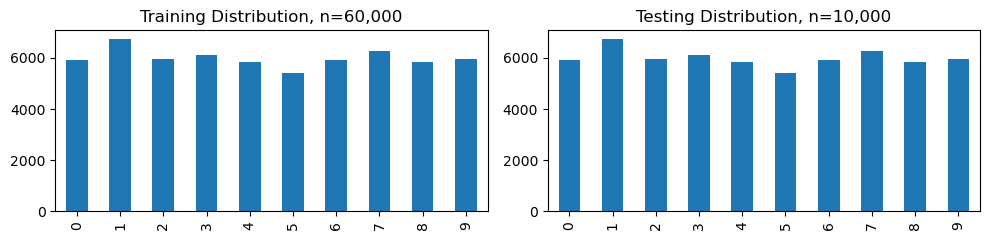

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

v_tr, c_tr = np.unique(y_tr, return_counts=True)
v_te, c_te = np.unique(y_te, return_counts=True)

s_tr = pd.Series(c_tr, index=v_tr)
s_te = pd.Series(c_tr, index=v_te)

fig, ax = plt.subplots(1, 2, figsize=(10, 2.5))

s_tr.plot(kind='bar', ax=ax[0])
s_te.plot(kind='bar', ax=ax[1])

ax[0].set_title(f'Training Distribution, n={X_tr.shape[0]:,}')
ax[1].set_title(f'Testing Distribution, n={X_te.shape[0]:,}')

plt.tight_layout()

## Display images

In [5]:
images = {y: [im for im, clazz in zip(X_tr, y_tr) if clazz == y][0] for y in range(10)}

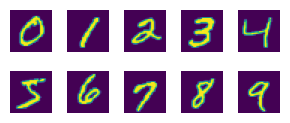

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(3, 1.5))

for (y, im), ax in zip(images.items(), np.ravel(axes)):
    ax.imshow(im)
    ax.set_axis_off()

plt.tight_layout()

## Save images

In [7]:
from pathlib import Path
import shutil

shutil.rmtree('./data/mnist')

v, _ = np.unique(y_tr, return_counts=True)
for number in v:
    p_tr = Path(f'./data/mnist/tr/{number:02}')
    p_te = Path(f'./data/mnist/te/{number:02}')
    
    p_tr.mkdir(parents=True, exist_ok=True)
    p_te.mkdir(parents=True, exist_ok=True)
    
    print(f'created: {p_tr} | {p_te}')

created: data/mnist/tr/00 | data/mnist/te/00
created: data/mnist/tr/01 | data/mnist/te/01
created: data/mnist/tr/02 | data/mnist/te/02
created: data/mnist/tr/03 | data/mnist/te/03
created: data/mnist/tr/04 | data/mnist/te/04
created: data/mnist/tr/05 | data/mnist/te/05
created: data/mnist/tr/06 | data/mnist/te/06
created: data/mnist/tr/07 | data/mnist/te/07
created: data/mnist/tr/08 | data/mnist/te/08
created: data/mnist/tr/09 | data/mnist/te/09


In [8]:
import cv2

def save_images(X, y, fold):
    counter = {int(num): 0 for num in v}

    for img, digit in zip(X, y):
        count = counter[int(digit)]
        p = f'./data/mnist/{fold}/{digit:02}/{count:04}.png'
        cv2.imwrite(p, img)

        counter[int(digit)] += 1
        
    return counter

In [9]:
save_images(X_tr, y_tr, 'tr')

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

In [10]:
save_images(X_te, y_te, 'te')

{0: 980,
 1: 1135,
 2: 1032,
 3: 1010,
 4: 982,
 5: 892,
 6: 958,
 7: 1028,
 8: 974,
 9: 1009}

## Verify saved images

In [11]:
def get_image(p):
    return cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)

def get_metadata(p):
    tokens = str(p).split('/')
    
    fold = tokens[2]
    clazz = tokens[3]
    filename = tokens[4]
    w, h, c = get_image(str(p)).shape
    
    return fold, clazz, filename, w, h, c
    
I_tr = pd.DataFrame(
    map(get_metadata, Path('./data/mnist/tr').glob('**/*.png')), 
    columns=['fold', 'clazz', 'filename', 'w', 'h', 'c']
)

I_te = pd.DataFrame(
    map(get_metadata, Path('./data/mnist/te').glob('**/*.png')), 
    columns=['fold', 'clazz', 'filename', 'w', 'h', 'c']
)

I_tr.shape, I_te.shape

((60000, 6), (10000, 6))

In [12]:
I_tr.assign(n=1).groupby(['clazz'])['n'].sum()

clazz
00    5923
01    6742
02    5958
03    6131
04    5842
05    5421
06    5918
07    6265
08    5851
09    5949
Name: n, dtype: int64

In [13]:
I_te.assign(n=1).groupby(['clazz'])['n'].sum()

clazz
00     980
01    1135
02    1032
03    1010
04     982
05     892
06     958
07    1028
08     974
09    1009
Name: n, dtype: int64